In [1]:
import re
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from IPython.core.display import display, HTML
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
warnings.filterwarnings('ignore')
pd.pandas.set_option('display.max_rows', None)
pd.pandas.set_option('display.max_columns', None)
display(HTML('<style>.container{width : 100% ! important;}</style>'))

In [2]:
df = pd.read_csv('IPL 1st Inningsv2.csv')

In [3]:
df.head()

,match_id,year,date,city,venue,team1,team2,toss_winner,toss_decision,innings,batting_team,bowling_team,batsman,non_striker,bowler,overs,balls,batsman_runs,extra_runs,total_runs,non_boundary,is_wicket,dismissal_kind,player_dismissed,fielder,extras_type,runs,wickets,runs_last_5_overs,wickets_last_5_overs,target_overs,target_runs,balls_remaining,runs_scored_in_remaining_balls,runs_required,winner,result,result_margin,player_of_match,playoff,knockout,final,method,players,umpire1,umpire2,final_score,total_wickets
0,335982,2008,2008-04-18,Bangalore,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,1,Kolkata Knight Riders,Royal Challengers Bangalore,SC Ganguly,BB McCullum,P Kumar,0,1,0.0,1.0,1.0,0,0,NaN,NaN,NaN,legbyes,1,0,1,0,NaN,NaN,119,221,0,Kolkata Knight Riders,runs,140.0,BB McCullum,0,0,0,NaN,"R Dravid, W Jaffer, V Kohli, JH Kallis, CL Whi...",Asad Rauf,RE Koertzen,222.0,3
1,335982,2008,2008-04-18,Bangalore,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,1,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,0,2,0.0,0.0,0.0,0,0,NaN,NaN,NaN,NaN,1,0,1,0,NaN,NaN,118,221,0,Kolkata Knight Riders,runs,140.0,BB McCullum,0,0,0,NaN,"R Dravid, W Jaffer, V Kohli, JH Kallis, CL Whi...",Asad Rauf,RE Koertzen,222.0,3
2,335982,2008,2008-04-18,Bangalore,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,1,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,0,3,0.0,1.0,1.0,0,0,NaN,NaN,NaN,wides,2,0,2,0,NaN,NaN,117,220,0,Kolkata Knight Riders,runs,140.0,BB McCullum,0,0,0,NaN,"R Dravid, W Jaffer, V Kohli, JH Kallis, CL Whi...",Asad Rauf,RE Koertzen,222.0,3
3,335982,2008,2008-04-18,Bangalore,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,1,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,0,3,0.0,0.0,0.0,0,0,NaN,NaN,NaN,NaN,2,0,2,0,NaN,NaN,117,220,0,Kolkata Knight Riders,runs,140.0,BB McCullum,0,0,0,NaN,"R Dravid, W Jaffer, V Kohli, JH Kallis, CL Whi...",Asad Rauf,RE Koertzen,222.0,3
4,335982,2008,2008-04-18,Bangalore,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,1,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,0,4,0.0,0.0,0.0,0,0,NaN,NaN,NaN,NaN,2,0,2,0,NaN,NaN,116,220,0,Kolkata Knight Riders,runs,140.0,BB McCullum,0,0,0,NaN,"R Dravid, W Jaffer, V Kohli, JH Kallis, CL Whi...",Asad Rauf,RE Koertzen,222.0,3


In [4]:
print(df.shape)
df = df[df['overs'] >= 5]
print(df.shape)

(107664, 48)
(81247, 48)


In [5]:
df = df[['venue', 'toss_decision', 'batting_team', 'bowling_team', 'overs', 'balls', 'runs', 'wickets', 'runs_last_5_overs', 
         'wickets_last_5_overs', 'balls_remaining', 'runs_scored_in_remaining_balls', 'playoff', 'knockout', 'final']]

In [6]:
dummy = ['batting_team', 'bowling_team', 'toss_decision', 'venue']
df_dummy = pd.get_dummies(df[dummy], prefix_sep = '_', drop_first = False)
df = df.drop(dummy, axis = 1)
df = pd.concat([df, df_dummy], axis = 1)

In [7]:
category = ['overs', 'balls', 'wickets']
for col in category:
    df[col] = df[col].astype('category', copy = False)

In [8]:
columns = []
for i in df.columns:
    i = re.sub('\s', '_', i)
    i = re.sub('\.', '', i)
    i = re.sub('\,', '', i)
    i = re.sub('\-', '_', i)
    columns.append(i)
df.columns = columns

In [9]:
df.columns

Index(['overs', 'balls', 'runs', 'wickets', 'runs_last_5_overs',
       'wickets_last_5_overs', 'balls_remaining',
       'runs_scored_in_remaining_balls', 'playoff', 'knockout', 'final',
       'batting_team_Chennai_Super_Kings', 'batting_team_Deccan_Chargers',
       'batting_team_Delhi_Capitals', 'batting_team_Gujarat_Lions',
       'batting_team_Kochi_Tuskers_Kerala',
       'batting_team_Kolkata_Knight_Riders', 'batting_team_Mumbai_Indians',
       'batting_team_Pune_Warriors', 'batting_team_Punjab_Kings',
       'batting_team_Rajasthan_Royals', 'batting_team_Rising_Pune_Supergiant',
       'batting_team_Royal_Challengers_Bangalore',
       'batting_team_Sunrisers_Hyderabad', 'bowling_team_Chennai_Super_Kings',
       'bowling_team_Deccan_Chargers', 'bowling_team_Delhi_Capitals',
       'bowling_team_Gujarat_Lions', 'bowling_team_Kochi_Tuskers_Kerala',
       'bowling_team_Kolkata_Knight_Riders', 'bowling_team_Mumbai_Indians',
       'bowling_team_Pune_Warriors', 'bowling_team_Pun

In [10]:
df = df[['batting_team_Chennai_Super_Kings', 'batting_team_Deccan_Chargers',
       'batting_team_Delhi_Capitals', 'batting_team_Gujarat_Lions',
       'batting_team_Kochi_Tuskers_Kerala',
       'batting_team_Kolkata_Knight_Riders', 'batting_team_Mumbai_Indians',
       'batting_team_Pune_Warriors', 'batting_team_Punjab_Kings',
       'batting_team_Rajasthan_Royals', 'batting_team_Rising_Pune_Supergiant',
       'batting_team_Royal_Challengers_Bangalore',
       'batting_team_Sunrisers_Hyderabad', 'bowling_team_Chennai_Super_Kings',
       'bowling_team_Deccan_Chargers', 'bowling_team_Delhi_Capitals',
       'bowling_team_Gujarat_Lions', 'bowling_team_Kochi_Tuskers_Kerala',
       'bowling_team_Kolkata_Knight_Riders', 'bowling_team_Mumbai_Indians',
       'bowling_team_Pune_Warriors', 'bowling_team_Punjab_Kings',
       'bowling_team_Rajasthan_Royals', 'bowling_team_Rising_Pune_Supergiant',
       'bowling_team_Royal_Challengers_Bangalore',
       'bowling_team_Sunrisers_Hyderabad', 'toss_decision_bat',
       'toss_decision_field', 'venue_Arun_Jaitley_Stadium',
       'venue_Barabati_Stadium', 'venue_Brabourne_Stadium',
       'venue_Buffalo_Park', 'venue_De_Beers_Diamond_Oval',
       'venue_Dr_DY_Patil_Sports_Academy',
       'venue_Dr_YS_Rajasekhara_Reddy_ACA_VDCA_Cricket_Stadium',
       'venue_Dubai_International_Cricket_Stadium', 'venue_Eden_Gardens',
       'venue_Green_Park',
       'venue_Himachal_Pradesh_Cricket_Association_Stadium',
       'venue_Holkar_Cricket_Stadium',
       'venue_JSCA_International_Stadium_Complex', 'venue_Kingsmead',
       'venue_M_Chinnaswamy_Stadium', 'venue_MA_Chidambaram_Stadium',
       'venue_Maharashtra_Cricket_Association_Stadium',
       'venue_Narendra_Modi_Stadium', 'venue_Nehru_Stadium',
       'venue_New_Wanderers_Stadium', 'venue_Newlands',
       'venue_OUTsurance_Oval',
       'venue_Punjab_Cricket_Association_IS_Bindra_Stadium',
       'venue_Rajiv_Gandhi_International_Stadium',
       'venue_Saurashtra_Cricket_Association_Stadium',
       'venue_Sawai_Mansingh_Stadium',
       'venue_Shaheed_Veer_Narayan_Singh_International_Stadium',
       'venue_Sharjah_Cricket_Stadium', 'venue_Sheikh_Zayed_Stadium',
       'venue_St_George\'s_Park', 'venue_SuperSport_Park',
       'venue_Vidarbha_Cricket_Association_Stadium', 'venue_Wankhede_Stadium', 'overs', 'balls', 'runs', 'wickets', 'runs_last_5_overs',
       'wickets_last_5_overs', 'balls_remaining',
       'runs_scored_in_remaining_balls', 'playoff', 'knockout', 'final']]

In [11]:
df.shape

(81247, 72)

In [12]:
X = pd.DataFrame(df.drop('runs_scored_in_remaining_balls', axis = 1), columns = df.drop('runs_scored_in_remaining_balls', axis = 1).columns)
y = df['runs_scored_in_remaining_balls']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 17)

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((73122, 71), (8125, 71), (73122,), (8125,))

In [15]:
X_train.columns

Index(['batting_team_Chennai_Super_Kings', 'batting_team_Deccan_Chargers',
       'batting_team_Delhi_Capitals', 'batting_team_Gujarat_Lions',
       'batting_team_Kochi_Tuskers_Kerala',
       'batting_team_Kolkata_Knight_Riders', 'batting_team_Mumbai_Indians',
       'batting_team_Pune_Warriors', 'batting_team_Punjab_Kings',
       'batting_team_Rajasthan_Royals', 'batting_team_Rising_Pune_Supergiant',
       'batting_team_Royal_Challengers_Bangalore',
       'batting_team_Sunrisers_Hyderabad', 'bowling_team_Chennai_Super_Kings',
       'bowling_team_Deccan_Chargers', 'bowling_team_Delhi_Capitals',
       'bowling_team_Gujarat_Lions', 'bowling_team_Kochi_Tuskers_Kerala',
       'bowling_team_Kolkata_Knight_Riders', 'bowling_team_Mumbai_Indians',
       'bowling_team_Pune_Warriors', 'bowling_team_Punjab_Kings',
       'bowling_team_Rajasthan_Royals', 'bowling_team_Rising_Pune_Supergiant',
       'bowling_team_Royal_Challengers_Bangalore',
       'bowling_team_Sunrisers_Hyderabad', 'to

In [20]:
cbr = CatBoostRegressor()
cbr.fit(X_train, y_train)

CatBoostError: features data: pandas.DataFrame column 'overs' has dtype 'category' but is not in  cat_features list

Cat Boost Regression:
----------------------------------------------------------------------------------------------------
Train r2_score:  0.9525381074900239
Test r2_score:  0.9492993752418563
----------------------------------------------------------------------------------------------------
Train RMSE:  8.79232650015186
Test RMSE:  9.122588535121574
----------------------------------------------------------------------------------------------------
Train MAE:  6.463873430908231
Test MAE:  6.688776276565442


<AxesSubplot:xlabel='runs_scored_in_remaining_balls', ylabel='Density'>

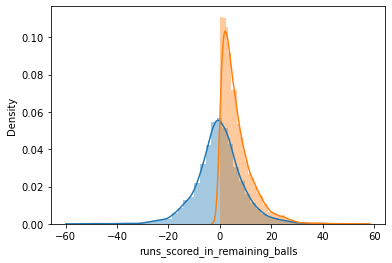

In [16]:
y_train_pred_cbr = cbr.predict(X_train)
y_test_pred_cbr = cbr.predict(X_test)
print('Cat Boost Regression:')
print('-' * 100)
print('Train r2_score: ', r2_score(y_train, y_train_pred_cbr))
print('Test r2_score: ', r2_score(y_test, y_test_pred_cbr))
print('-' * 100)
print('Train RMSE: ', np.sqrt(mean_squared_error(y_train, y_train_pred_cbr)))
print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, y_test_pred_cbr)))
print('-' * 100)
print('Train MAE: ', mean_absolute_error(y_train, y_train_pred_cbr))
print('Test MAE: ', mean_absolute_error(y_test, y_test_pred_cbr))
sns.distplot(y_test - y_test_pred_cbr)
sns.distplot(abs(y_test - y_test_pred_cbr))

In [17]:
tdf = X_test

In [18]:
tdf['actual'] = y_test
tdf['predicted'] = y_test_pred_cbr

In [19]:
tdf.to_csv('1stTEMPDATA.csv', index = None)

In [21]:
file = open('regressor.pkl', 'wb')
pickle.dump(cbr, file)
file.close()